In [19]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pilot_academy.data.io import read_fn
import tensorflow as tf
from typing import Iterable, Tuple
from functools import partial

In [2]:
# Paths
PROJECT_DIR = Path("/workspaces/pilot_academy")
DATA_DIR = PROJECT_DIR / "data" / "all_towns_with_weather" / "raw"
RUN_DIR = PROJECT_DIR / "outputs" / "2026-01-24" / "16-12-12_command_vit_baseline"
IMAGES_DIR = DATA_DIR / "images"

df_path = DATA_DIR / "df_annotations.csv"
label_to_id_path = DATA_DIR / "label_to_id.json"
action_to_id_path = DATA_DIR / "action_to_id.json"
model_path = RUN_DIR / "checkpoints" / "model.keras"

In [ ]:
# Load annotations
df_annotations = pd.read_csv(df_path, index_col="frame_index")

# Load mappings
with open(action_to_id_path) as f:
    action_to_id = json.load(f)

with open(label_to_id_path) as f:
    label_to_id = {
        tuple(k.split("|")): int(v)
        for k, v in json.load(f).items()
    }

# Collect images
image_paths = sorted(IMAGES_DIR.glob("*.png"))
if not image_paths:
    raise FileNotFoundError(f"No PNG images found in {IMAGES_DIR}")



# Configuration
crop_ymin = 100
grayscale = True

configured_read_fn = partial(
    read_fn,
    crop_ymin=crop_ymin,
    grayscale=grayscale,
)

In [30]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def sample_images_by_class(
    df_annotations: pd.DataFrame,
    image_dir: str | Path,
    *,
    class_ids=(1, 2, 9),
    n_samples: int = 8,
    read_fn=None,
    seed: int = 0,
):
    rng = np.random.default_rng(seed)
    image_dir = Path(image_dir)

    out = []
    for cid in class_ids:
        df_c = df_annotations[df_annotations["class_id"] == cid]
        if len(df_c) == 0:
            continue

        k = min(n_samples, len(df_c))
        sampled = df_c.sample(n=k, random_state=seed, replace=False)

        for _, row in sampled.iterrows():
            image_name = row["image_name"]
            img_path = image_dir / image_name
            image = read_fn(img_path) if read_fn is not None else None

            out.append(
                {
                    "class_id": int(cid),
                    "image": image,
                    "image_name": image_name,
                    "steering": float(row["steering_angle"]),
                    "driver_action": row["driver_action"],
                    "road_context": row["road_context"],
                }
            )
    return out


def plot_samples_by_class(
    df_annotations: pd.DataFrame,
    image_dir: str | Path,
    *,
    class_ids=(1, 2, 9),
    n_samples: int = 5,
    read_fn,
    seed: int = 0,
    figsize_per_cell=(3.2, 3.0),
):
    samples = sample_images_by_class(
        df_annotations,
        image_dir,
        class_ids=class_ids,
        n_samples=n_samples,
        read_fn=read_fn,
        seed=seed,
    )

    by_class = {cid: [] for cid in class_ids}
    for s in samples:
        if s["class_id"] in by_class:
            by_class[s["class_id"]].append(s)

    n_cols = len(class_ids)
    n_rows = n_samples

    fig_w = figsize_per_cell[0] * n_cols
    fig_h = figsize_per_cell[1] * n_rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), squeeze=False)

    for c, cid in enumerate(class_ids):
        col_samples = by_class.get(cid, [])
        for r in range(n_rows):
            ax = axes[r, c]
            ax.axis("off")

            if r >= len(col_samples):
                ax.set_title(f"class {cid}\n(no sample)", fontsize=9)
                continue

            s = col_samples[r]
            img = s["image"]

            if img is None:
                ax.set_title("image=None", fontsize=9)
                continue

            # Handle possible CHW or HWC
            if isinstance(img, np.ndarray):
                if img.ndim == 3 and img.shape[0] in (1, 3) and img.shape[-1] not in (1, 3):
                    img_to_show = np.transpose(img, (1, 2, 0))
                else:
                    img_to_show = img
            else:
                img_to_show = img

            ax.imshow(img_to_show.squeeze(), cmap="gray" if img_to_show.ndim == 2 or img_to_show.shape[-1] == 1 else None)

            title = f"{s['image_name']}\nsteer={s['steering']:.4f}\n{s['road_context']}"
            ax.set_title(title, fontsize=8)

    plt.tight_layout()
    plt.show()

    return samples


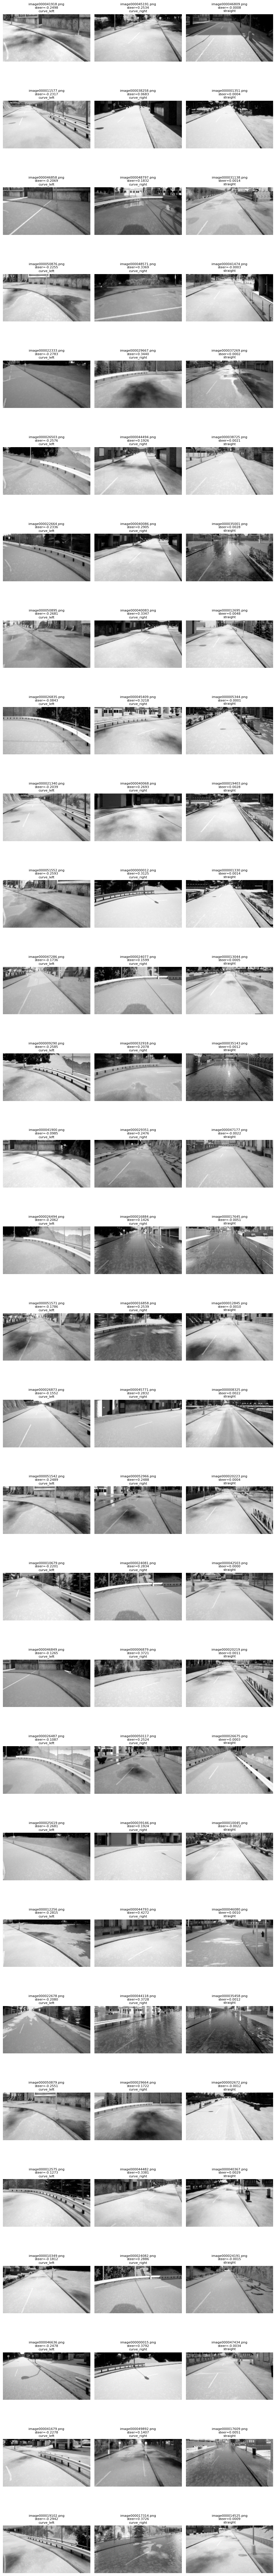

In [33]:
samples = plot_samples_by_class(
    df_annotations,
    image_dir=IMAGES_DIR,
    class_ids=[1, 2, 9],
    n_samples=30,
    read_fn=configured_read_fn,
    seed=0,
)

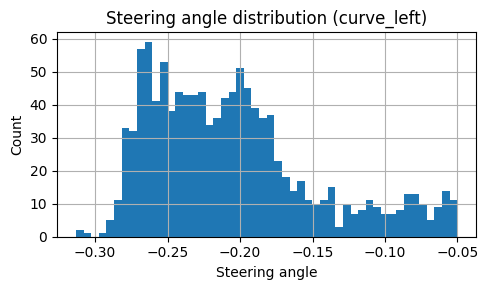

In [34]:
import matplotlib.pyplot as plt

# Filter left-curve samples
angles = df_annotations.loc[
    df_annotations["road_context"] == "curve_left",
    "steering_angle",
]

# Histogram
plt.figure(figsize=(5, 3))
plt.hist(angles, bins=50)
plt.xlabel("Steering angle")
plt.ylabel("Count")
plt.title("Steering angle distribution (curve_left)")
plt.grid(True)
plt.tight_layout()
plt.show()
